<a href="https://colab.research.google.com/github/mrityunjay2627/LLM-From-Scratch/blob/main/LLM_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation and Sampling

How do you prepare input text for training LLMs?

Step 1: Splitting text into individual word/tokens and convert tokens into token IDs

Step 2: Encode token IDs into vector representations

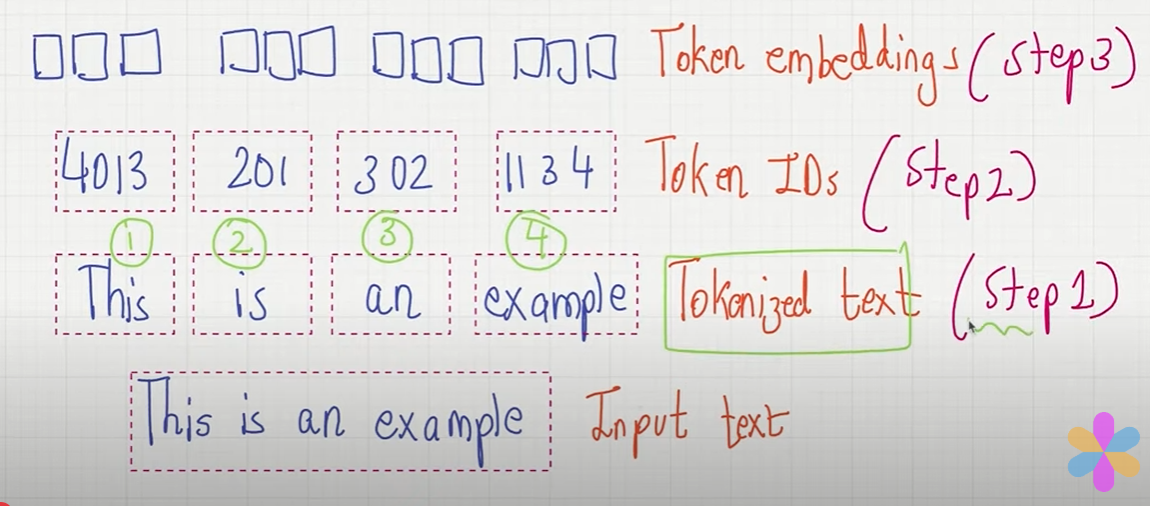

### Tokenizing Text

Dataset used: `The Verdict` by Edith Wharton

In [9]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Our goal is to tokenize this 20,479-character short story into individual words and special characters that we can then turn into embeddings for LLM training

Note that it's common to process millions of articles and hundreds of thousands of books -- many gigabytes of text -- when working with LLMs. However, for educational purposes, it's sufficient to work with smaller text samples like a single book to illustrate the main ideas behind the text processing steps and to make it possible to run it in reasonable time on consumer hardware.

How can we best split this text to obtain a list of tokens? For this, we go on a small excursion and use Python's regular expression library re for illustration purposes. (Note that you don't have to learn or memorize any regular expression syntax since we will transition to a pre-built tokenizer later in this chapter.)

Using some simple example text, we can use the re.split command with the following syntax to split a text on whitespace characters:

In [10]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


The result is a list of individual words, whitespaces, and punctuation characters:
Let's modify the regular expression splits on whitespaces (\s) and commas, and periods ([,.]):


In [11]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


We can see that the words and punctuation characters are now separate list entries just as we wanted.

A small remaining issue is that the list still includes whitespace characters. Optionally, we can remove these redundant characters safely as follows:

In [12]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


REMOVING WHITESPACES OR NOT When developing a simple tokenizer, whether we should encode whitespaces as separate characters or just remove them depends on our application and its requirements. Removing whitespaces reduces the memory and computing requirements.

However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing). Here, we remove whitespaces for simplicity and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme that includes whitespaces.

The tokenization scheme we devised above works well on the simple sample text. Let's modify it a bit further so that it can also handle other types of punctuation, such as question marks, quotation marks, and the double-dashes we have seen earlier in the first 100 characters of Edith Wharton's short story, along with additional special characters:

In [13]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']
['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']
['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


Now that we got a basic tokenizer working, let's apply it to Edith Wharton's entire short story:

In [14]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [15]:
print(len(preprocessed))

4690


### Creating Token IDs

In the previous section, we tokenized Edith Wharton's short story and assigned it to a Python variable called preprocessed. Let's now create a list of all unique tokens and sort them alphabetically to determine the vocabulary size:

In [16]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


After determining that the vocabulary size is 1,130 via the above code, we create the vocabulary and print its first 51 entries for illustration purposes:

In [17]:
vocab = {token:integer for integer,token in enumerate(all_words)}

In [18]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


As we can see, based on the output above, the dictionary contains individual tokens associated with unique integer labels.

Later in this book, when we want to convert the outputs of an LLM from numbers back into text, we also need a way to turn token IDs into text. For this, we can create an inverse version of the vocabulary that maps token IDs back to corresponding text tokens.

Let's implement a complete tokenizer class in Python. The class will have an encode method that splits text into tokens and carries out the string-to-integer mapping to produce token IDs via the vocabulary. In addition, we implement a decode method that carries out the reverse integer-to-string mapping to convert the token IDs back into text.

Step 1: Store the vocabulary as a class attribute for access in the encode and decode methods

Step 2: Create an inverse vocabulary that maps token IDs back to the original text tokens

Step 3: Process input text into token IDs

Step 4: Convert token IDs back into text

Step 5: Replace spaces before the specified punctuation

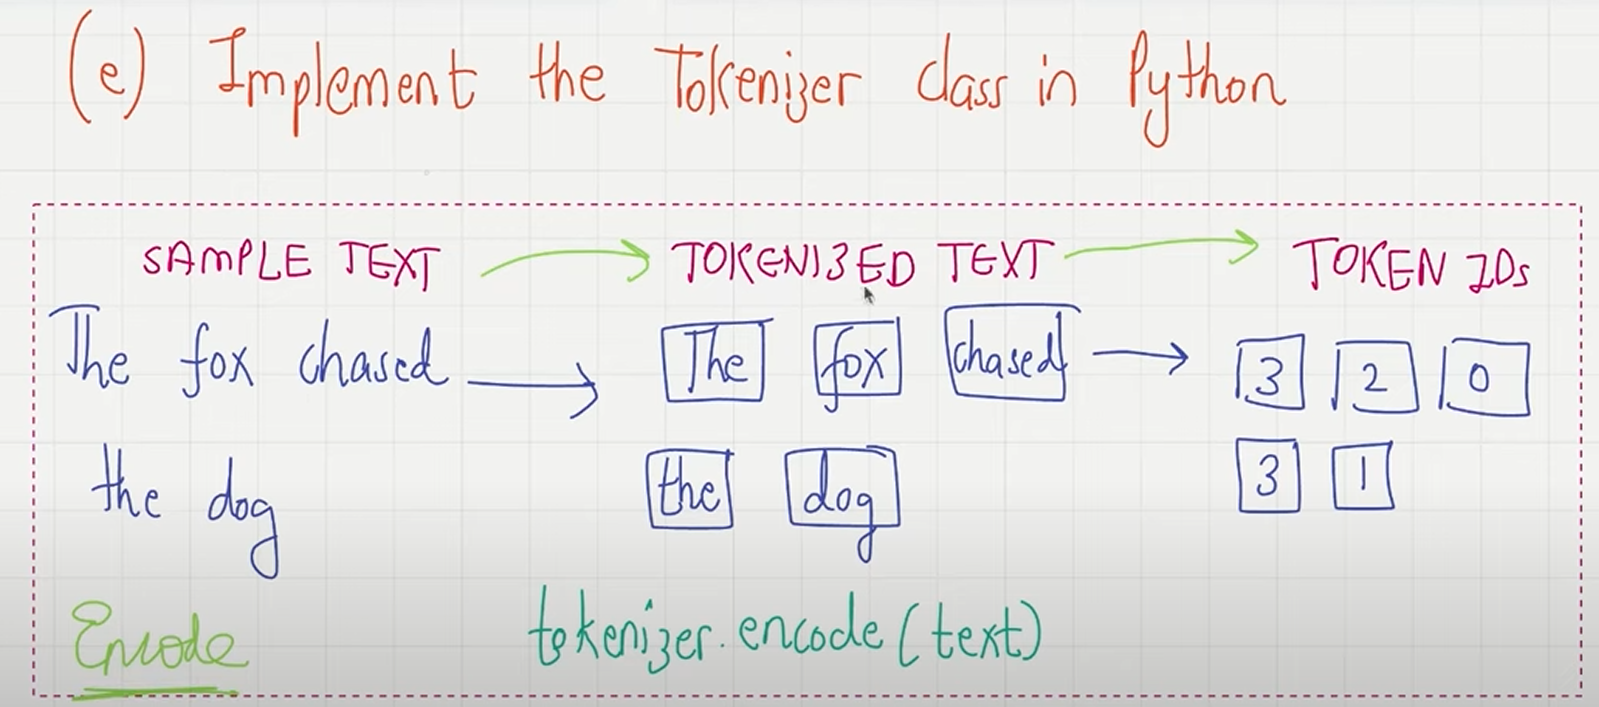

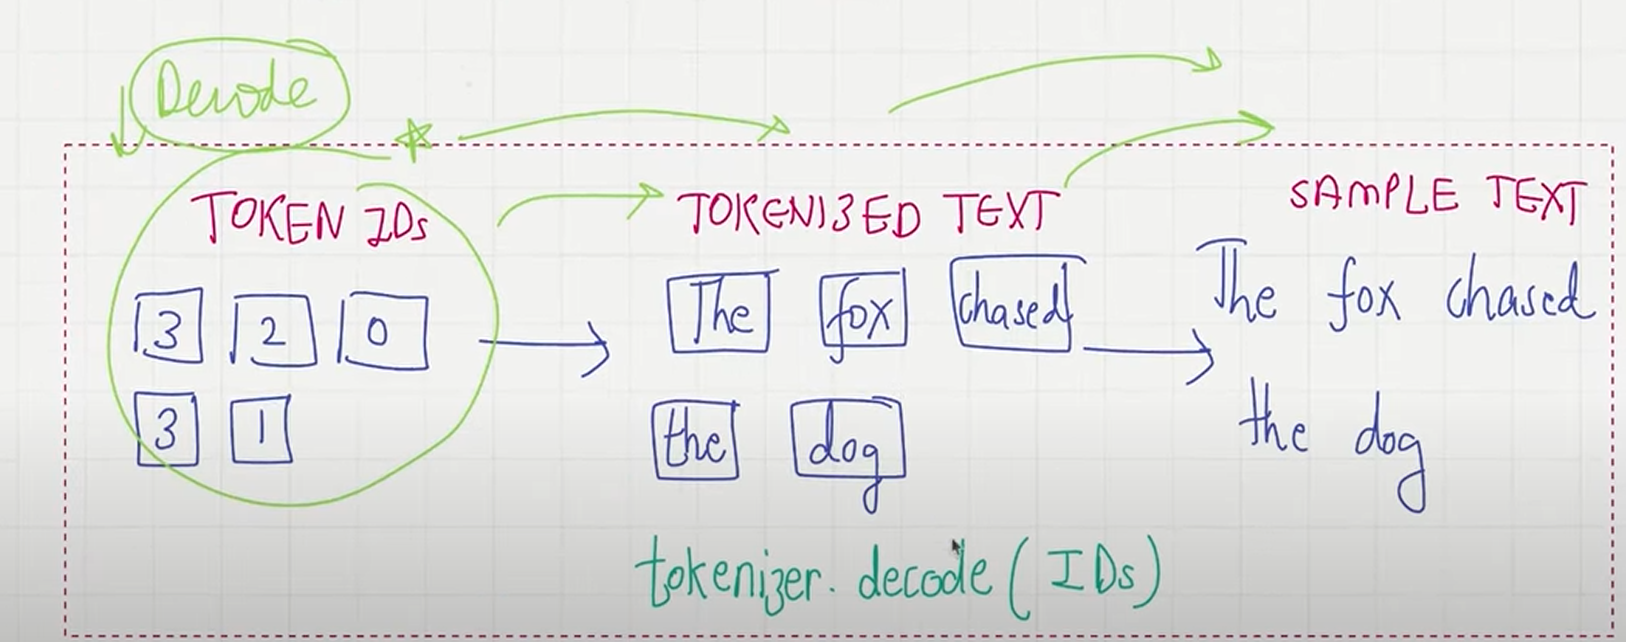

In [19]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

Let's instantiate a new tokenizer object from the SimpleTokenizerV1 class and tokenize a passage from Edith Wharton's short story to try it out in practice:

In [20]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


The code above prints the following token IDs: Next, let's see if we can turn these token IDs back into text using the decode method:

In [21]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

Based on the output above, we can see that the decode method successfully converted the token IDs back into the original text.

So far, so good. We implemented a tokenizer capable of tokenizing and de-tokenizing text based on a snippet from the training set. Let's now apply it to a new text sample that is not contained in the training set:

In [22]:
# text = "Hello, do you like tea?"
# print(tokenizer.encode(text))

The problem is that the word "Hello" was not used in the The Verdict short story. Hence, it is not contained in the vocabulary. This highlights the need to consider large and diverse training sets to extend the vocabulary when working on LLMs.

### ADDING SPECIAL CONTEXT TOKENS

In the previous section, we implemented a simple tokenizer and applied it to a passage from the training set.

In this section, we will modify this tokenizer to handle unknown words.

In particular, we will modify the vocabulary and tokenizer we implemented in the previous section, SimpleTokenizerV2, to support two new tokens, <|unk|> and <|endoftext|>

We can modify the tokenizer to use an <|unk|> token if it encounters a word that is not part of the vocabulary.

Furthermore, we add a token <|endoftext|> between unrelated texts. For example, when training GPT-like LLMs on multiple independent documents or books, it is common to insert a <|endoftext|> token before each document or book that follows a previous text source. This token allows the llm to process the data and understand the data in much better manner.

Let's now modify the vocabulary to include these two special tokens, by adding these to the list of all unique words that we created in the previous section:

In [23]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [24]:
len(vocab.items())

1132

Based on the output of the print statement above, the new vocabulary size is 1132 (the vocabulary size in the previous section was 1130).

As an additional quick check, let's print the last 5 entries of the updated vocabulary:

In [25]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


Step 1: Replace unknown words by <|unk|> tokens

Step 2: Replace spaces before the specified punctuations

In [26]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [27]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [28]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [29]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

Based on comparing the de-tokenized text above with the original input text, we know that the training dataset, Edith Wharton's short story The Verdict, did not contain the words "Hello" and "palace."

So far, we have discussed tokenization as an essential step in processing text as input to LLMs. Depending on the LLM, some researchers also consider additional special tokens such as the following:

[BOS] (beginning of sequence): This token marks the start of a text. It signifies to the LLM where a piece of content begins.

[EOS] (end of sequence): This token is positioned at the end of a text, and is especially useful when concatenating multiple unrelated texts, similar to <|endoftext|>. For instance, when combining two different Wikipedia articles or books, the [EOS] token indicates where one article ends and the next one begins.

[PAD] (padding): When training LLMs with batch sizes larger than one, the batch might contain texts of varying lengths. To ensure all texts have the same length, the shorter texts are extended or "padded" using the [PAD] token, up to the length of the longest text in the batch.

Note that the tokenizer used for GPT models does not need any of these tokens mentioned above but only uses an <|endoftext|> token for simplicity

The tokenizer used for GPT models also doesn't use an <|unk|> token for outof-vocabulary words. Instead, GPT models use a byte pair encoding tokenizer, which breaks down words into subword units

### BYTE PAIR ENCODING

#### BPE Tokenizer

Sub-Word Based Tokenization (Best of both Word Based and Character Based Tokenization)

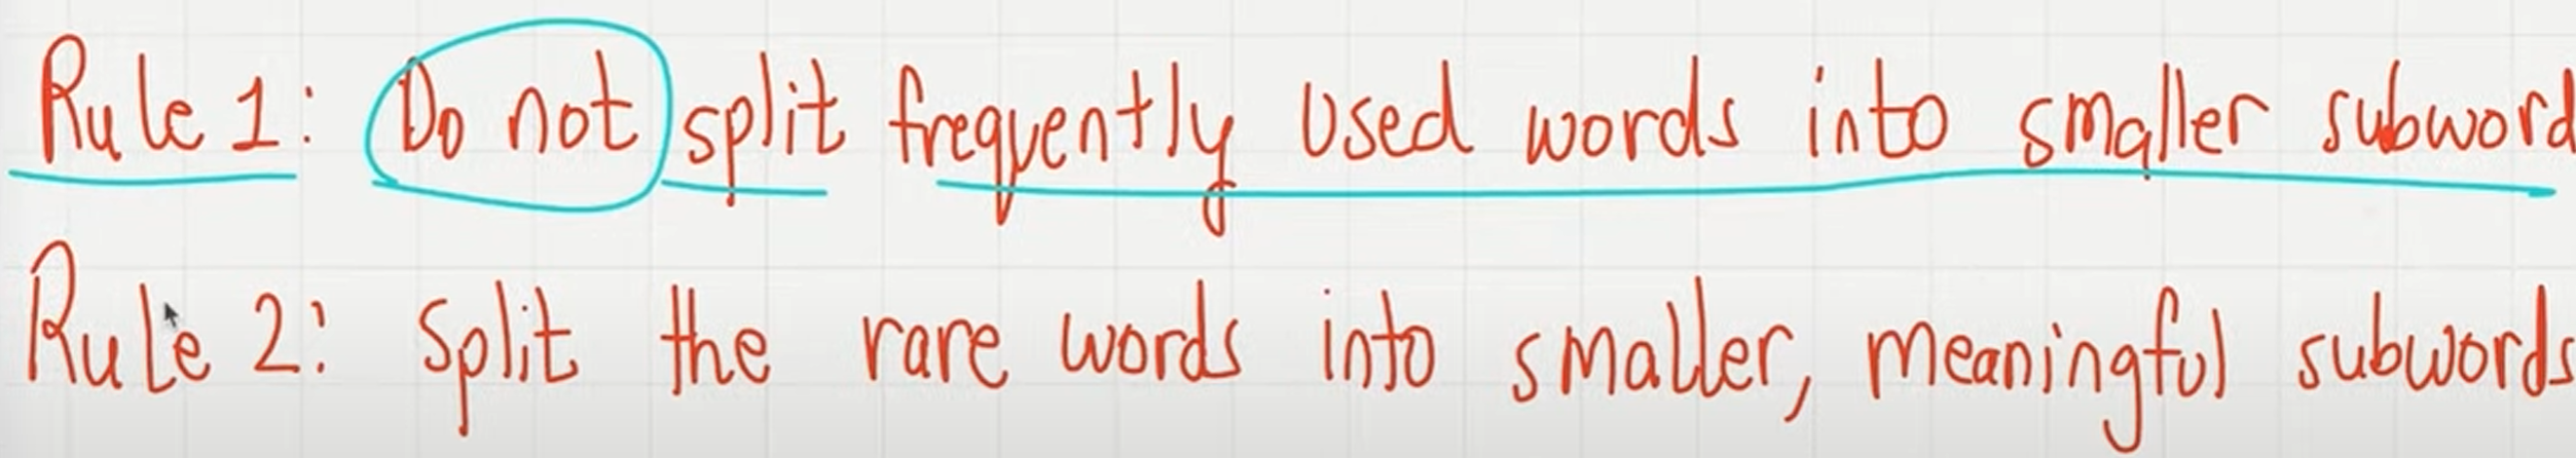

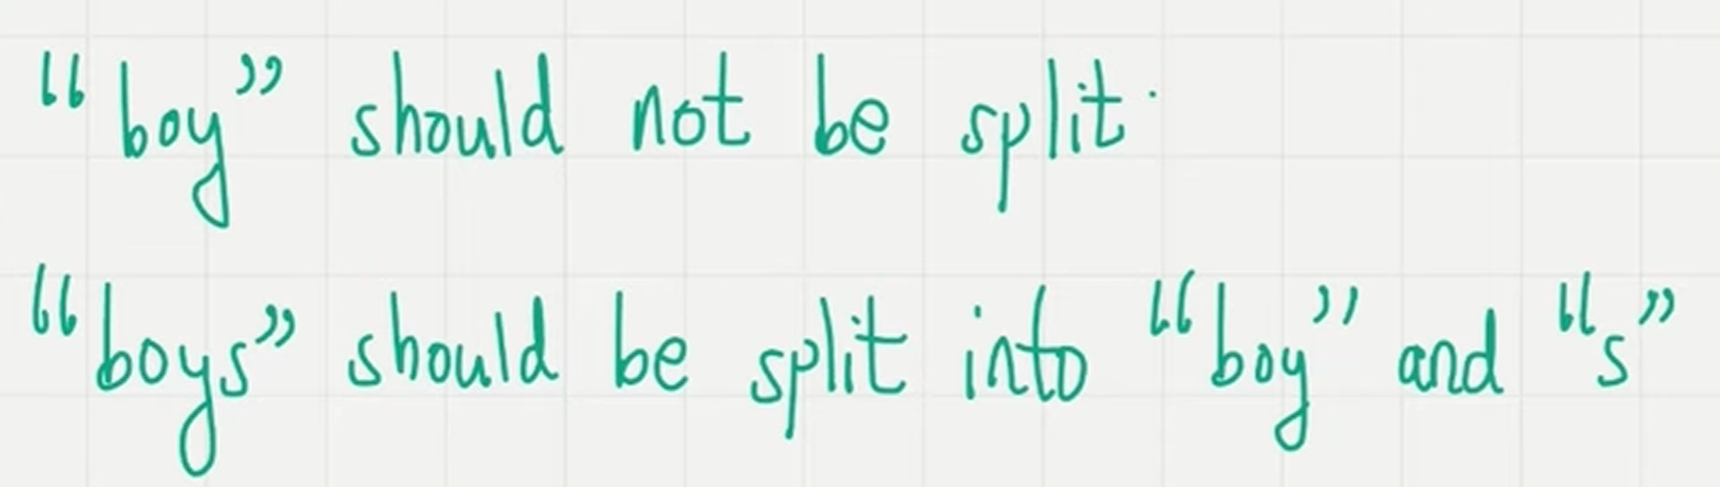

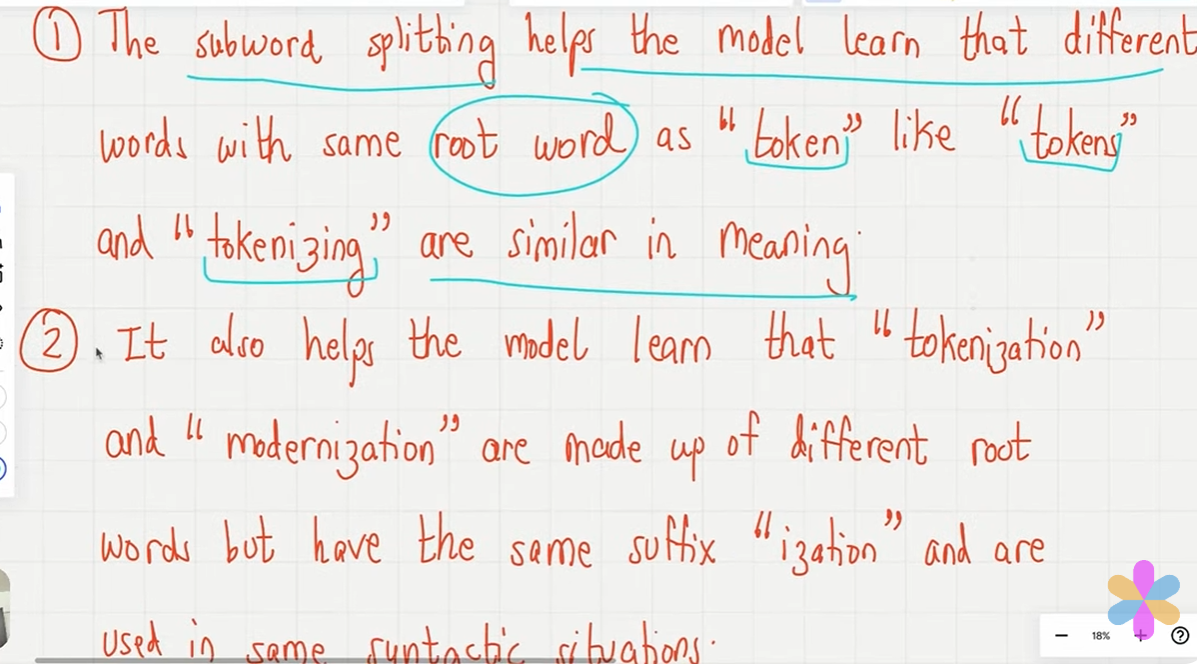

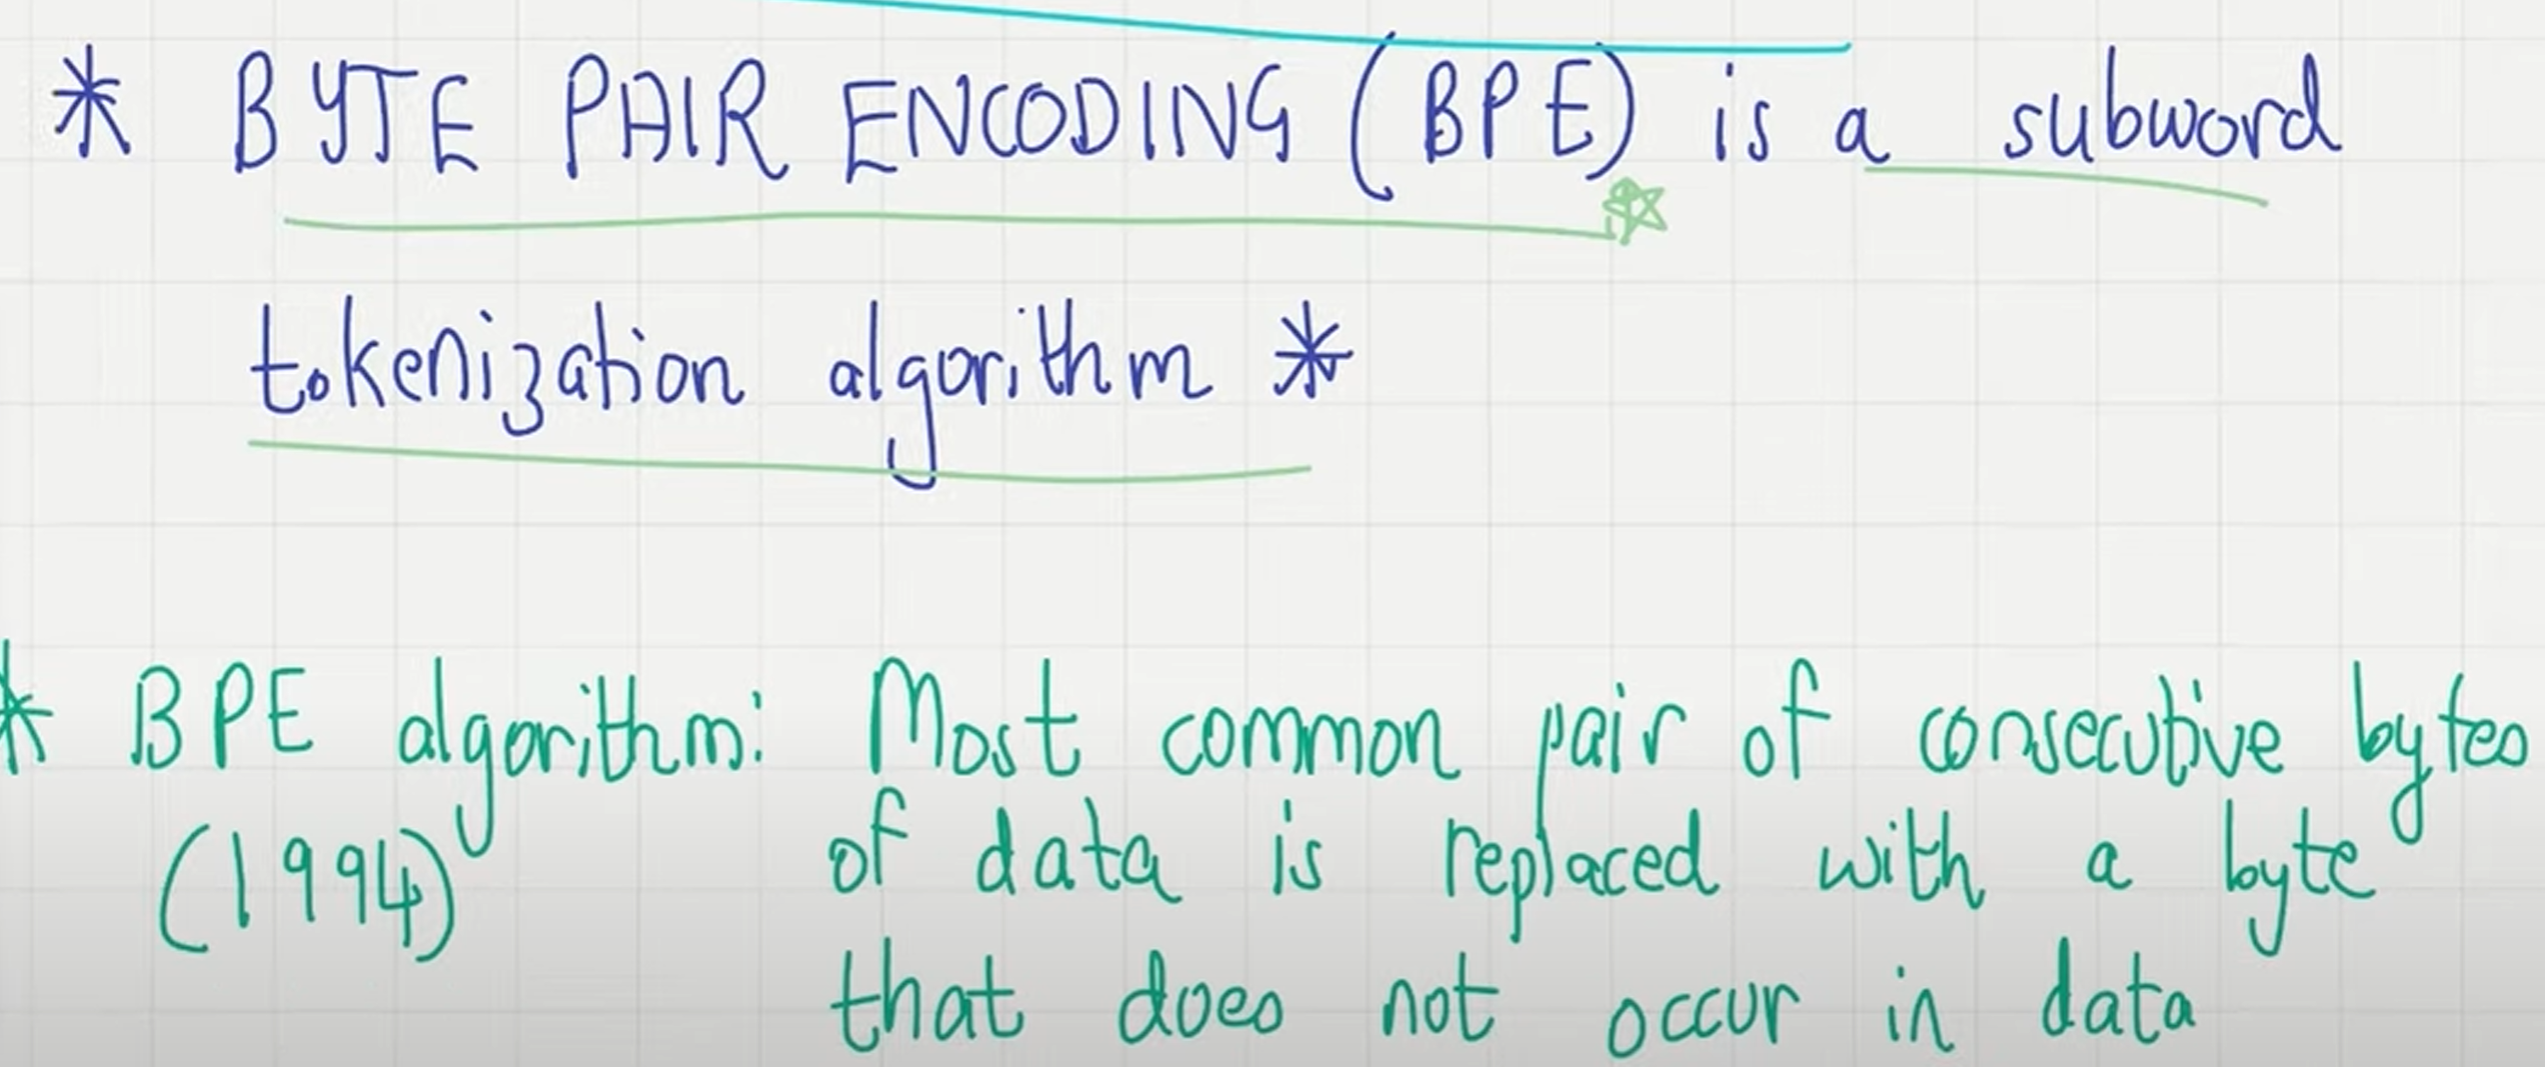

In [33]:
!pip3 install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00


In [34]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [35]:
tokenizer = tiktoken.get_encoding("gpt2")

In [39]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

print(text)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.
[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [37]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


We can make two noteworthy observations based on the token IDs and decoded text
above.

First, the <|endoftext|> token is assigned a relatively large token ID, namely,
50256.

In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3,
and the original model used in ChatGPT, has a total vocabulary size of 50,257, with
<|endoftext|> being assigned the largest token ID.

Second, the BPE tokenizer above encodes and decodes unknown words, such as "someunknownPlace" correctly.

The BPE tokenizer can handle any unknown word. How does it achieve this without using <|unk|> tokens?

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters.

The enables it to handle out-ofvocabulary words.

So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters

The **stopping criteria** of training BPE can either be **token count** or **the number of iterations**

**Let us take another simple example to illustrate how the BPE tokenizer deals with unknown tokens**

In [38]:
integers = tokenizer.encode("Akwirw ier")
print(integers)

strings = tokenizer.decode(integers)
print(strings)

[33901, 86, 343, 86, 220, 959]
Akwirw ier
